# Group Analysis of ERP Data

## Load packages

In [1]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output
import matplotlib.pyplot as plt
import numpy as np
import glob

## Define parameters

We define a list of experimental conditions; that's about the only parameter we need to define here.

In [2]:
conditions = ['Control', 'Violation']

## Find data files

We list all the `-ave.fif` files (`Evoked` data sets) associated with this experiment:

In [3]:
data_dir = 'data'
data_files = glob.glob(data_dir + '/sentence_n400_p*-ave.fif' )
data_files

['data/sentence_n400_p22-ave.fif',
 'data/sentence_n400_p14-ave.fif',
 'data/sentence_n400_p04-ave.fif',
 'data/sentence_n400_p05-ave.fif',
 'data/sentence_n400_p15-ave.fif',
 'data/sentence_n400_p23-ave.fif',
 'data/sentence_n400_p17-ave.fif',
 'data/sentence_n400_p07-ave.fif',
 'data/sentence_n400_p21-ave.fif',
 'data/sentence_n400_p20-ave.fif',
 'data/sentence_n400_p06-ave.fif',
 'data/sentence_n400_p16-ave.fif',
 'data/sentence_n400_p13-ave.fif',
 'data/sentence_n400_p03-ave.fif',
 'data/sentence_n400_p25-ave.fif',
 'data/sentence_n400_p24-ave.fif',
 'data/sentence_n400_p02-ave.fif',
 'data/sentence_n400_p12-ave.fif',
 'data/sentence_n400_p26-ave.fif',
 'data/sentence_n400_p09-ave.fif',
 'data/sentence_n400_p19-ave.fif',
 'data/sentence_n400_p10-ave.fif',
 'data/sentence_n400_p01-ave.fif',
 'data/sentence_n400_p11-ave.fif',
 'data/sentence_n400_p18-ave.fif',
 'data/sentence_n400_p08-ave.fif']

## Load data files

In the previous lesson on averaging trials for an individual participant, we ended by saving the list of MNE `Evoked` objects (representing the averages across trials for each condition) in a single file for that participant. 

Here, we will load in the files from a group of participants. To work with them easily and efficiently in MNE, we will store them as a dictionary, where each key is a condition label, and each value is a list of `Evoked` objects (the data from that condition, with each participant's `Evoked` as a list item).

Here when we `read_evokeds()` you will likewise get a list of `Evoked` objects. Lists are a bit tricky since they don't contain labels. In the previous lesson we addressed this by manually changing the `.comment` field of each `Evoked` object to clearly label it. As well, in the case of the present data (as is good practice in any data science pipeline), we used the same code to generate all of the Evoked files, so the two experimental conditions occur in the same order in each `-ave.fif` file. Since each participant's data was saved in the same order, index 0 in the list will always be the same condition for all participants. For this reason, we can use `enumerate()` to loop over conditions and build our dictionary of `Evoked` objects here.

Note that we use list comprehension to build the list of Evoked objects for each condition, and we use the index from `enumerate()` (`idx`) to specify which condition (list item) we read from each participant's data file:

In [4]:
evokeds = {}

for idx, c in enumerate(conditions):
    evokeds[c] = [mne.read_evokeds(d)[idx] for d in data_files]

evokeds

{'Control': [<Evoked | 'Control' (average, N=40), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=35), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=39), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=38), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=41), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=33), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=40), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=40), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=34), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=40), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=32), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control'

## Compare Evoked waveforms

`mne.viz.plot_compare_evokeds()` will recognize a dictionary of Evoked objects and use the keys as condition labels. Furthermore, when it sees that each value in the dictionary is a list of Evoked objects, it will combine them and plot not only the mean across the list (i.e., across participants, for each condition), but also the 95% confidence intervals (CIs), representing the variability across participants. As we learned in the [EDA] chapter, CIs are a useful way of visually assessing whether different conditions are likely to be statistically significantly different. In this case, the plot shows evidence of an N400 effect. The difference between conditions is largest between ~350–650 ms, and the CIs are most distinct (overlapping little or not at all) between 500–650 ms.

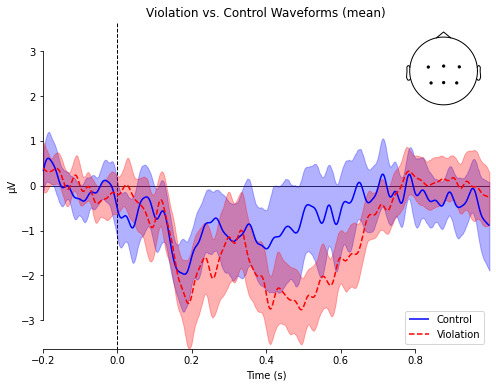

In [5]:
# Define plot parameters
roi = ['C3', 'Cz', 'C4', 
       'P3', 'Pz', 'P4']

color_dict = {'Control':'blue', 'Violation':'red'}
linestyle_dict = {'Control':'-', 'Violation':'--'}


mne.viz.plot_compare_evokeds(evokeds,
                             combine='mean',
                             legend='lower right',
                             picks=roi, show_sensors='upper right',
                             colors=color_dict,
                             linestyles=linestyle_dict,
                             title='Violation vs. Control Waveforms'
                            )
plt.show()

## Differences

As we did in the single-participant analysis, we can also create difference waves to more easily visualize the difference between conditions, and compare it to zero (i.e., no difference between conditions). 

In order to get CIs that reflect the variance across participants, we need to compute the *Violation-Control* difference separately for each participant. As we did for a single participant's data, we use `mne.combine_evoked()` for this, with a weight of `1` for *Violation* and `-1` for *Control*. The only difference here is we put this function in a loop over participants. 

In [6]:
diff_waves = []
for i in range(len(data_files)):
    diff_waves.append(mne.combine_evoked([evokeds['Violation'][i], evokeds['Control'][i]],
                                          weights=[1, -1]
                                         )
                     )

diff_waves

[<Evoked | 'Violation - Control' (average, N=20.0), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=17.74647887323944), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=18.986842105263158), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=19.0), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=19.9875), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=16.5), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=18.37837837837838), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=19.487179487179485), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=16.484848484848484), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violatio

## Plot difference waveform

In making the difference waveform above, we simply created a list of `Evoked` objects. We didn't create a dictionary since there is only one contrast (*Violation-Control*), so no need to have informative dictionary keys for a set of different items (contrasts). This is fine, however MNE's  `plot_compare_evokeds()` is a bit picky when it comes to its inputs, and whether it draws CIs or not. Specifically, the [API](https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html) reads:
> If a list of Evokeds, the contents are plotted with their .comment attributes used as condition labels... If a dict whose values are Evoked objects, the contents are plotted as single time series each and the keys are used as labels. If a [dict/list] of lists, the unweighted mean is plotted as a time series and the parametric confidence interval is plotted as a shaded area.

In other words, when the function gets a list of `Evoked` objects as input, it will draw each object as a separate waveform, but if it gets a dictionary in which each entry is a list of `Evoked` objects, if will average them together and draw CIs. Since we desire the latter behaviour here, in the command below we create a dictionary "on the fly" inside the plotting command, with a key corresponding to the label we want, and the value being the list of difference waves. 

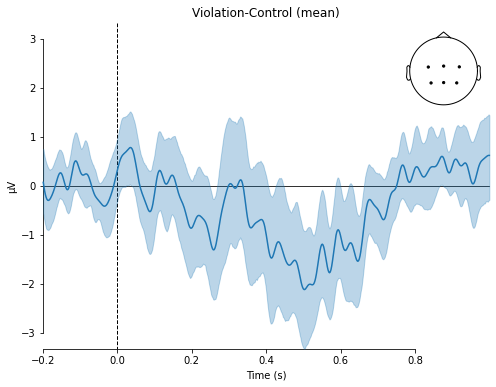

In [7]:
contrast = 'Violation-Control'
mne.viz.plot_compare_evokeds({contrast:diff_waves}, combine='mean',
                            legend=None,
                            picks=roi, show_sensors='upper right',
                            title=contrast
                            )
plt.show()

## Scalp topographic map

As with `plot_compare_evoked()`, it's important to understand what type of data the `plot_evoked_topomap()` function needs in order to get it to work right. Whereas `plot_compare_evoked()` will average over a list of `Evoked` objects, `plot_evoked_topomap()` will only accept a single Evoked object as input. Therefore, in the command below we apply the `mne.grand_average()` function to the list of `Evoked` objects (**Grand averaging** is a term used in EEG research to refer to an average across participants; this terminology developed to distinguish such an average from an average across trials, for a single participant).

Here we plot the topographic map for the average amplitude over a 200 ms period, centered on 500 ms (i.e., 300–500 ms). 

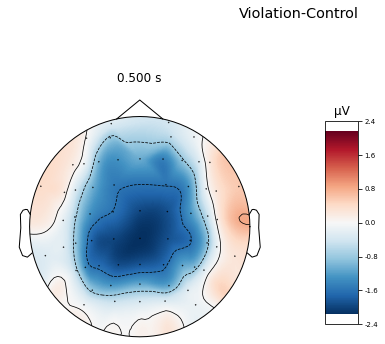

In [8]:
mne.viz.plot_evoked_topomap(mne.grand_average(diff_waves), 
                            times=.500, average=0.200, 
                            title=contrast,
                            size=3
                           )
plt.show()

We can add a few enhancements to the plot to make it more interpretable:
- The `show_names` kwarg tells the function to plot the names of each channel rather than just dots at each location.
- The `contours=False` kwarg turns off the dashed contour lines you can see above. This is a matter of personal preference, however I feel that these are like non-continuous colour scales, in that they provide visual indicators of discontinuous "steps" in the scalp electrical potential values, when in fact these vary smoothly and continuously. 
- We increase the `size` to make the channel labels a bit easier to read (unfortunately the function doesn't provide a kwarg to adjust the font size of these).

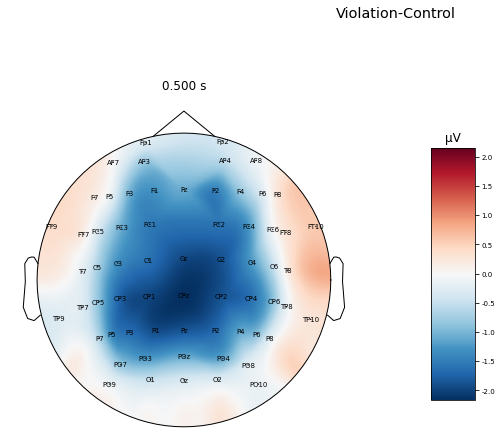

In [9]:
mne.viz.plot_evoked_topomap(mne.grand_average(diff_waves), 
                            times=.500, average=0.200, 
                            title=contrast,
                            show_names=True,
                            contours=False,
                            size=4
                           );

## Statistical analyses

### A priori *t* test
A common approach to testing whether an ERP effect is significant is to perform a *t* test between a pair of conditions, on the ERP data averaged over a time period of interest and at one or a few electrodes. Ideally, the experimenter should have an *a priori* (i.e., defined prior to running the experiment) hypothesis regarding the time window and electrodes at which the ERP component and experimental effect of interest would be largest. In the present case, we predicted an N400, which we knew from previous studies with similar stimuli would likely be largest between 400–600 ms, at electrode Pz. 

In this case, we will use the `ttest_1samp()` function from SciPy's `stats` module. This tests whether a set of values are different from zero. So we use as input the *Violation-Control* differences for each participant, since if they are significantly different from zero, that will be evidence for a difference in amplitude between these two conditions. 

So here we first compute the average over the 400–600 ms time window, for each participant, at electrode Pz, and store these in a NumPy array on which we then perform the *t* test. We create the NumPY array in a single line of code, but it's a fairly complex one:
- we use list comprehension to loop over each participant (`for e in diff_waves`)
- for each participant's `Evoked` object, we use the `.get_data()` method to extract the ERP data
    - we use the `picks` kwarg to specify which electrode(s) we want. In this cases, we specify a single electrode, however we could pass a list of several electrodes if we wanted.
    - we use the `tmin` and `tmax` kwargs to specify the time range over which we want to extract the ERP data
- The result of `get_data` will be a NumPy array of values at each time point in the time range we specified. We apply `np.mean()` to the result of `get_data`, to average across the 400-600 ms time window. We pass the `axis=1` kwarg because the NumPy array will be 2D, with a row for each electrode (in this case, only 1 row), and columns for time. So `axis=1` tells `np.mean()` to average over columns (axis 1; time) and not rows (axis 0; electrodes).
- Since we used list comprehension to loop across participants, we end up with a list of NumPy arrays (one for each participant). Thus the outermost (last applied) function below is `np.array()` to convert the list of values from each participant to a NumPy array, because `ttest_1samp()` requires a NumPy array as input.

In [10]:
evoked_data = np.array([np.mean(e.get_data(picks='Pz', tmin=.400, tmax=.600), axis=1) for e in diff_waves])

Now we perform the *t*-test. Note that `ttest_1samp()` produces NumPy arrays for its outputs (which here we assign to `t` and `pval`), even when we only performed one *t*-test. So when we print the results on the last line, we need to use `t[0]` and `p[0]` rather than simply `t` and `p`.

In [11]:
from scipy import stats 

t, pval = stats.ttest_1samp(evoked_data, 0)
print('Difference t = ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Difference t =  -2.93 p =  0.0071


## Permutation *t* test and multiple comparison correction

Another approach is to perform a *t* test at *every* electrode, so that we can visualize a statistical map of values across the scalp. This has the advantage of potentially revealing the true scalp distribution of an experimental effect, rather than being limited to the channel(s) predicted a priori to show the effect. 

However, this increases our risk of false positives (Type I error). This is because when we perform a *t* test and use the resulting *p* value to determine statistical significance, we typically pick a threshold for significance (alpha, or $\alpha$) based on the probability of finding a result by chance, if no experimental effect were actually present. In other words, if we use an $\alpha$ of .05, this means there is on average a 5% probability of finding that result by chance.  However, that is based on the assumption that we ran only one statistical test. If we run multiple statistical tests, and use *p* ≤ .05 as our threshold, then we increase the odds of finding at least one "significant" result by chance. Most intuitively, if we perform 100 statistical tests and use *p* ≤ .05 on each, then we are likely to end up with 5 of those results being incorrect (5/100 = 5%).

In the present data we have data from 64 electrodes for each participant. One way to correct for multiple comparisons is the **Bonferroni** method, which involves simply dividing the desired $\alpha$ value for the experiment (i.e., across all tests) by the number of tests. For this data set that would mean $.05 / 64 = 0.00078$. However, the Bonferroni correction assumes that each statistical test is independent of the others, which is not true for multiple channels of EEG data — nearby channels can be predicted to have similar values, since they are measuring activity from nearby scalp locations. 

There are several alternative ways of controlling for multiple comparisons. One is to perform a **permutation** *t* test. Widely introduced to the field of neuroimaging by [Nichols and Holmes (2001)](https://doi.org/10.1002/hbm.1058)permutation is a well-established approach in the field of statistics. The basic concepts in permutation testing are *exchangability* and *randomization*. If we have multiple data points from two sets of experimental conditions (e.g., *Violation* and *Control*), and there is no true difference between the conditions, then it should not matter if we perform a *t* test between the data points using the correct condition labels, or if we randomly re-label the condition of each data point (i.e., *exchange* the labels among data points). In other words, if ERP amplitude in the *Violation* and *Control* conditions are not truly different, then if we scramble which data points we call *Violation* and which ones we call *Control*, and perform the *t* test again, the results of that *t* test should not be too different from the "correct" *t* test. On the other hand, if there is a true experimental effect, then randomizing the labels of each data point should result in consistently lower *t* values than the true labeling. The reason this approach is called *permutation* testing is that we perform the random exchange of labels and data points many times, each with a different reassignment (i.e., a different permutation of labels and data points). Typically this is done thousands of times, in order to get a reliable estimate of the *null distribution* — that is, the distribution of *t* scores across different permutations that we know don't match the true label-to-data-point mapping. 

This approach doesn't in and of itself correct for multiple comparisons. However, when permutation tests are performed over a number of different sets of data (such as a separate *t* test on the data from each individual electrode), can can use this to correct for multiple comparisons. This is called the **maximal statistic** method. It is based on the recognition that the distribution of *t* (and associated *p*) values across thousands of random permutations of labels actually reflects the "chance" that our use *p* values are based on. In other words, in conventional *t* tests if we use an $\alpha$ of .05, then we are saying that we accept a 5% chance that over many replications of the experiment we would get a "significant" result by chance. Since our permutation distribution actually *is* thousands of replications of an "experiment" in which there is no true effect, we can say that the top 5% of the *t* values we obtain from the permutations are what we consider "significant". We can provide even better control for multiple comparisons by looking at the maximum *t* values not just at each electrode separately, but across all the electrodes. We can set the critical *t* value (i.e., the *t* threshold for significance) to be $(\alpha * N) + 1$, where $N$ is the number of electrodes. That is, our *t* threshold is set so that just under 5% of the randomly-obtained *t* values are greater than this threshold. 

### Performing a permutation *t* test

MNE provides a `permutation_t_test()` function which we import here. 

In [12]:
from mne.stats import permutation_t_test

The `permutation_t_test()` function only allows for a 1-sample test, so — similar to the single-electrode *t* test above — we will run this on the *Violation-Control* differences for each participant. So we then create a NumPy array of data from the difference waves of each of our participants. The only difference from the previous example is that we don't use `picks` to select a channel; we extract data from all channels. We do average over our *a priori* time window of interest however.

In [13]:
evoked_data = np.array([np.mean(e.get_data(tmin=.400, tmax=.600), axis=1) for e in diff_waves])

To run the test, we have to specify the number of permutations, here we use MNE's suggested value of 50,000. We also use the `tail=-1` kwarg to specify a 1-tailed test that predicts a negative *t* score. This is because the N400 manifests as a greater negativity.

In [14]:
n_permutations = 50000
T0, p_values, H0 = permutation_t_test(evoked_data, n_permutations, tail=-1)

The result of `permutation_t_test()` is three NumPY arrays:
- the *t* values for each channel
- the *p* values for each channel (corrected for multiple comparisons)
- `H0`, which is the null distribution — the maximum *t* value obtained during each permutation. This is the distribution that was used to determine the significance threshold. We don't actually need to use it, because the corrections are all done by the `permutation_t_test()`, but it's nice to know it's there if we want to check.

In [15]:
T0

array([-0.57080358, -0.78438487,  0.34835262, -2.11381352, -2.05960118,
       -1.80485844,  0.70287527, -1.09101426, -2.71791099, -2.83404371,
       -0.32752973, -0.99348145, -2.85223302, -3.22648929, -2.52654325,
        0.38805246, -1.5039293 , -2.60796913, -3.44881633, -3.30694221,
       -2.57367496,  1.5039293 , -3.0754765 , -3.36663645, -2.93349562,
       -2.26302196, -1.08830748, -0.52104647, -1.34525076, -0.9639556 ,
       -0.85953252, -0.6152627 , -0.07731113, -1.54813276, -1.1683513 ,
       -0.29418639, -0.45670357, -2.32021222, -2.55827164, -0.7602541 ,
        1.10853944,  0.25464935, -2.31532559, -2.51929001,  0.91885973,
        2.34076753, -2.00110272, -2.59168734, -3.20453629, -1.55360864,
       -1.22215648, -3.67798169, -3.55926501, -3.46564789, -0.88086133,
       -3.45152841, -3.49481003, -3.15971938, -2.40859398, -2.19467569,
       -2.55486174, -1.96350269, -2.22094286, -0.70239699])

In [16]:
p_values

array([1.     , 0.9998 , 1.     , 0.46156, 0.4951 , 0.66828, 1.     ,
       0.98556, 0.16928, 0.13468, 1.     , 0.9943 , 0.12974, 0.05794,
       0.23994, 1.     , 0.85492, 0.20716, 0.03518, 0.0483 , 0.22024,
       1.     , 0.08104, 0.04214, 0.10998, 0.37194, 0.98604, 1.     ,
       0.92366, 0.99602, 0.99886, 1.     , 1.     , 0.82996, 0.97314,
       1.     , 1.     , 0.339  , 0.22632, 0.99998, 1.     , 1.     ,
       0.34152, 0.24314, 1.     , 1.     , 0.53346, 0.21324, 0.06084,
       0.82686, 0.96192, 0.02058, 0.02724, 0.03368, 0.99834, 0.03484,
       0.03136, 0.06734, 0.29288, 0.41158, 0.22814, 0.55904, 0.39634,
       1.     ])

In [17]:
H0.shape

(50000,)

If we plot a histogram of the maximum *t* values from `H0`, we see that the bulk values are between 1–5, with a long tail extending out on the positive end to just above 8. Note that because of how the `permutation_t_test` function is written, these values are all positive, even though our actual predicted significant *t* values will be negative. 

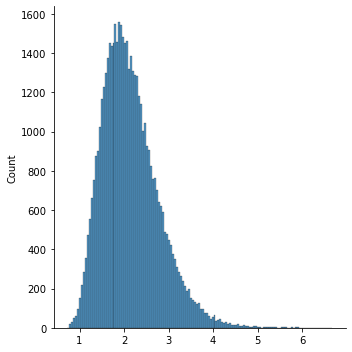

In [18]:
import seaborn as sns
sns.displot(data=H0)
plt.show()

We can use a function `np.argpartition()` to sort the `H0` values and split them at a particular cutoff. This is specified in terms of indexes in the NumPy array, so if we want the top 5% of *t* values, we have to compute the split as the number of permutations (the length of `H0`) multiplied by .05, which will tell as that 5% of 50,000 is 2500. (If you want to understand the details of this code, see [this StackExchange post](https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array) and the [API for `np.argpartition()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argpartition.html).)

In [19]:
thresh = round(n_permutations * .05)
split = np.argpartition(H0, -thresh)[-thresh:]

Our permutation-corrected *t* threshold will be the lowest value in `split`, because `split` contains the largest 5% of *t* values in the distribution:

In [20]:
t_thresh = sorted(H0[split])[0]
print(t_thresh)

3.292894047657986


We can also plot the histogram just of this top 5% of *t* values. We set the *y* axis limit to be comparable to the full distribution of *t* values above. 

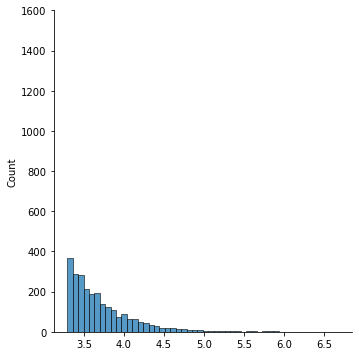

In [22]:
sns.displot(data=H0[split])
plt.ylim(0, 1600)
plt.show()

We can apply a mask to the *t* values from each electrode to see which ones are significant at our threshold. We need to put the `-` sign in front of `t_thresh` since we are predicting negative *t* values.

In [23]:
T0 < -t_thresh

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False,  True,  True, False, False, False, False, False, False,
       False])

We can see that there are 7 significant channels across the scalp. We can visualize them by plotting a topographic statistical map of the head, in which the colours reflect the *p* values, and significant electrodes are shown as white dots. 

To do this, we create a new `Evoked` object in which the data values are the *p* values from our permutation *t* test. The data we use in this `Evoked` are the negative log of the *p* values, which transforms the values so that the most significant *p* values become the largest values after transformation. This means that when we plot the *p* values, "bigger" means "more significant", which is the way we normally and intuitively interpret colour maps. 

The code below references `evokeds[conditions[0]][0].info` simply to copy the header from one of our actual evoked data sets to the newly-created one. This is important because to make a topographic plot, we'll need information like channel positions and possibly labels. 



In [24]:
evoked_p = mne.EvokedArray(-np.log10(p_values)[:, np.newaxis],
                         evokeds[conditions[0]][0].info, tmin=0.)

To highlight the significant electrodes, we will need a mask like the one above that is True where the *t* test was significant, and False elsewhere. We use `p_values[:, np.newaxis]` rather than just `p_values`, so that the mask is a 2D (1 x n_channels) array with the values in a single column, because this is how the `plot_topomap()` function requires the mask to be formatted. `np.newaxis` is a [tool in NumPy](https://numpy.org/doc/stable/reference/constants.html#numpy.newaxis) for increasing the number of dimensions in an array. 

In [25]:
mask = p_values[:, np.newaxis] <= 0.05

Finally, we generate the topographic plot. A few new or unusual kwargs are worth noting:
- Since this is a map of *p* values, "time" doesn't make sense, however the function requires a `times` value otherwise it defaults to plotting 4 time points (so in this case, 4 copies of the same plot)
- `scalings=1` rounds the numerical values on the colour bar to 1 decimal place
- the `Reds` cmap is used because the default Red-Blue map doesn't make sense for -log(p) values, which cannot be negative.
- we use `vmin` to specify the minimum value for the colour scale to be 0, since the minimum value in the data is not zero, but it makes sense for the colourmap to use white to mean zero
- the `mask` is used to highlight significant electrodes

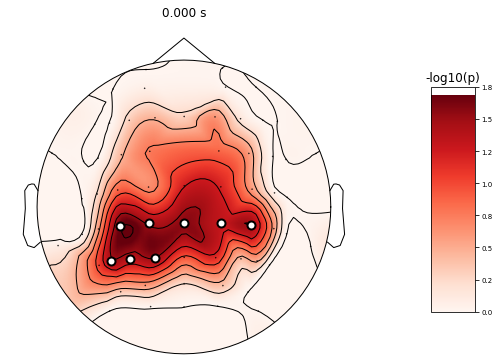

In [26]:
evoked_p.plot_topomap(times=0, 
                    scalings=1,
                    cmap='Reds', 
                    vmin=0,
                    units='-log10(p)', 
                    mask=mask,
                    size=4)
plt.show()